<a href="https://colab.research.google.com/github/mkkim007/Hackathon-KaggleFestival/blob/main/Restaurant_Visitor_Forecasting_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/Data/recruit-restaurant-visitor-forecasting.zip /content/

In [35]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
import datetime
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
import matplotlib.pyplot as plt
import seaborn as sns
import gc



In [4]:
!unzip -qq /content/recruit-restaurant-visitor-forecasting.zip

데이터를 나중에 합치기 위해서
air의 id든 hpg의 id든 모두 store_id로 통합

In [44]:
data_path = '../content/'
air_reserve = pd.read_csv(data_path + 'air_reserve.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv.zip').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv.zip').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv.zip').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv.zip')
date_info = pd.read_csv(data_path + 'date_info.csv.zip')
submission = pd.read_csv(data_path + 'sample_submission.csv.zip')

## 1.변수 설명 

---
**air_reserve.csv**

: *air* 레스토랑 예약 시스템

- `air_store_id` - the restaurant's id in the air system

- `visit_datetime` - the time of the reservation

- `reserve_datetime` - the time the reservation was made

- `reserve_visitors` - the number of visitors for that reservation

In [45]:
air_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


---
**hpg_reserve.csv**

: *hpg* 레스토랑 예약 시스템



- `hpg_store_id` - the restaurant's id in the hpg system

- `visit_datetime` - the time of the reservation

- `reserve_datetime` - the time the reservation was made

- `reserve_visitors` - the number of visitors for that reservation

  

In [46]:
hpg_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


---
**air_store_info.csv**

: *air*  레스토랑 세부 정보

- `air_store_id`

- `air_genre_name`

- `air_area_name`

- `latitude`

- `longitude`



In [47]:
air_store.head()

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


---
**hpg_store_info.csv**

: *hpg* 레스토랑 세부 정보



- `hpg_store_id`

- `hpg_genre_name`

- `hpg_area_name`

- `latitude`

- `longitude`

In [48]:
hpg_store.head()

,store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


---
**store_id_relation.csv**

:  *air* & *hpg* id 관계



- `hpg_store_id`

- `air_store_id`

In [49]:
store_id_map.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


나중에 hpg id를 air id 로 바꿔줄때 편하게 하기 위해서??

In [50]:
store_id_map.set_index('hpg_store_id',drop=False)

,air_store_id,hpg_store_id
hpg_store_id,,
hpg_4bc649e72e2a239a,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
hpg_c34b496d0305a809,air_a24bf50c3e90d583,hpg_c34b496d0305a809
hpg_cd8ae0d9bbd58ff9,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
hpg_de24ea49dc25d6b8,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
hpg_653238a84804d8e7,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
hpg_0cc0abae3a8b52de,air_b8925441167c3152,hpg_0cc0abae3a8b52de
hpg_098e4dd30e54fee6,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
hpg_1004356dc8ab69ec,air_6607fe3671242ce3,hpg_1004356dc8ab69ec


---
**air_visit_data.csv**

: air restaurants의 과거 방문 data.

- `air_store_id`

- `visit_date - the date`

- `visitors` - the number of visitors to the restaurant on the date -> 목적변수(y)

In [51]:
air_visit.head()

,store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


---
**sample_submission.csv**

:  *test* set으로 사용.

- `id` - the id is formed by concatenating the air_store_id and visit_date with an underscore

- `visitors`- the number of visitors forecasted for the store and date combination

In [54]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0



---
**date_info.csv**

: 일본 공휴일 정보

- `calendar_date`

- `day_of_week`

- `holiday_flg` - is the day a holiday in Japan

In [55]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [56]:
date_info.rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0
...,...,...
512,2017-05-27,0
513,2017-05-28,0
514,2017-05-29,0
515,2017-05-30,0


---
[참고](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r)

## 2. EDA 

### 데이터 합치기

`submission` 데이터는 `id`에 `visit_date`와 `store_id` 가 합쳐 져있습니다. 

In [15]:
submission.head()

,id,visitors,visit_date,store_id
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9


그러나 `air_visit` 데이터는 `store_id` 와 `visit_date` 로 나누어 져있습니다.

In [57]:
air_visit.head()

,store_id,visit_date,visitors,id
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18


둘을 합치기 위해 submission 에는 store_id와 visit_data를 추가해주고 air_visit에는 id를 추가해줍니다

In [14]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

In [ ]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
air_visit.head()

In [26]:
df = air_visit.groupby('visit_date').sum().reset_index()
df['visit_month'] = df['visit_date'].str[:7]
df1 = df.groupby('visit_month').sum().reset_index()

(0.0, 15.0)

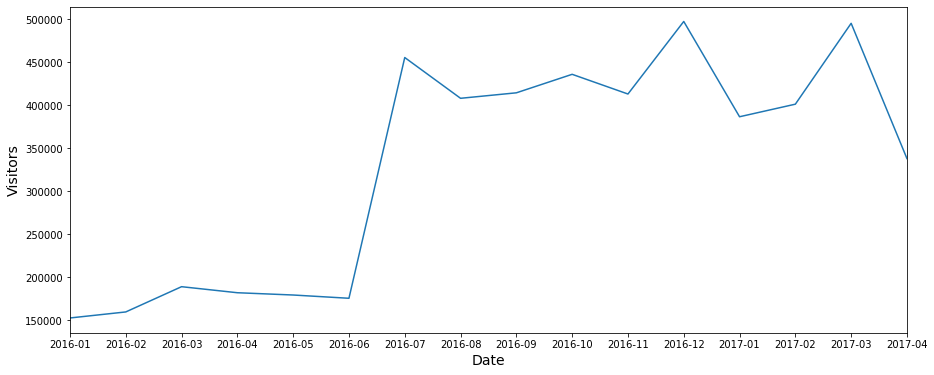

In [43]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,1,1)
ax.plot(df1['visit_month'], df1['visitors'], linestyle = '-')
ax.set_ylabel('Visitors', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
date_1 = datetime.datetime(2015,12,1)
date_2 = datetime.datetime(2017,6,1)
ax.set_xlim('2016-01', '2017-04')


In [8]:
#submission['visit_date'] = submission['id'].str[-10:]
#submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
